In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import random
from tqdm.auto import tqdm
from torch.utils.data import Subset
from collections import OrderedDict
random.seed(42)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = '/home/akansh-i2sc/Desktop/Study/HLCV/Why-Self-Supervision-in-Time/data/EuroSAT'   ### Change the path when you are running the code @hewan
batch_size = 64  
num_epochs = 20  
lr = 0.001  
weight_decay = 0.0005
init_idx = 0
backbone = [models.resnet50, models.resnet18][1] # 0: resnet50, 1: resnet18
init = torch.load("/home/akansh-i2sc/Desktop/Study/HLCV/Why-Self-Supervision-in-Time/src/models/pre-trained_weights/resnet18_model_seco.pth")
img_size = 64
training_type = ['fine_tuning', 'linear_probe']

In [3]:
resnet18_new = models.resnet18()
backbone_new = nn.Sequential(*list(resnet18_new.children())[:-1],nn.Flatten())
backbone_new.load_state_dict(init["resnet18_parameters"])
new_fc = nn.Linear(in_features=512, out_features=10, bias=True)
new_model = nn.Sequential(backbone_new,new_fc)

TO DO: 
- Data Description, train, test split and their distribution

In [11]:
def select_percentage_of_train_dataset(dataset, percentage):
    class_counts = {}
    indices_by_class = {}

    # Count the number of samples in each class
    for idx, (_, label) in enumerate(dataset):
        if label not in class_counts:
            class_counts[label] = 0
            indices_by_class[label] = []
        class_counts[label] += 1
        indices_by_class[label].append(idx)

    selected_indices = []

    # Select a percentage of samples from each class
    for _, indices in indices_by_class.items():
        num_samples = int(len(indices) * percentage)
        selected_samples = random.sample(indices, num_samples)
        selected_indices.extend(selected_samples)

    selected_data = Subset(dataset, selected_indices)
    return selected_data


# def model_def(backbone, training_type, weights, num_classes, device = torch.device("cuda" if torch.cuda.is_available() else "cpu")):
#     model = backbone(weights=weights)
#     num_features = model.fc.in_features
#     model.fc = nn.Linear(num_features, num_classes)
#     if training_type == 'fine_tuning':
#         for param in model.parameters():
#             param.requires_grad = True
#     elif training_type == 'linear_probe':
#         for param in model.parameters():
#             param.requires_grad = False
#         for param in model.fc.parameters():
#             param.requires_grad = True
#     else:
#         raise ValueError('Invalid training type!')
#     return model.to(device)


def model_def(model, training_type, device = torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    if training_type == 'fine_tuning':
        for param in model.parameters():
            param.requires_grad = True
    elif training_type == 'linear_probe':
        for param in model.parameters():
            param.requires_grad = False
        for param in model[-1].parameters():
            param.requires_grad = True
    else:
        raise ValueError('Invalid training type!')
    return model.to(device)

def train_model(model, selected_train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device, save_dir):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []
    best_acc = 0.0
    best_loss = float('inf')

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch} of {num_epochs}')
        correct = 0
        iterations = 0
        iter_loss = 0.0

        model.train()  

        for i, (inputs, labels) in enumerate(selected_train_loader):
            if device:
                inputs = inputs.to(device)
                labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            iter_loss += loss.item() 
            optimizer.zero_grad() 
            loss.backward()  
            optimizer.step()  

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum()
            iterations += 1

        scheduler.step()

        train_loss.append(iter_loss / iterations)
        train_accuracy.append((100 * correct / len(selected_train_loader.dataset)))

        test_acc, test_losses = evaluate_model(model, test_loader, criterion, device)

        test_loss.append(test_losses)
        test_accuracy.append(test_acc)

        print(f'Epoch {epoch} Train results: Loss={train_loss[-1]:.4f} | Accuracy={train_accuracy[-1]:.2f}%')
        print(f'Epoch {epoch} Test results: Loss={test_loss[-1]:.4f} | Accuracy={test_accuracy[-1]:.2f}%\n')

        if test_acc > best_acc:
            best_acc = test_acc
            # torch.save(model.state_dict(), os.path.join(save_dir, 'best_acc_model.pth'))

        if test_losses < best_loss:
            best_loss = test_losses
            # torch.save(model.state_dict(), os.path.join(save_dir, 'best_loss_model.pth'))

    # Save the final model
    # torch.save(model.state_dict(), os.path.join(save_dir, 'final_model.pth'))

    return train_loss, train_accuracy, test_loss, test_accuracy


def evaluate_model(model, test_loader, criterion, device):
    model.eval()  
    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            if device:
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / len(test_loader.dataset)

    return accuracy, test_loss

In [12]:
#Data transforms and dataloaders
data_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'train'), data_transforms)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'test'), data_transforms)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=2, pin_memory=True)

num_classes = len(train_dataset.classes)
class_names = train_dataset.classes
print("Classes:", class_names)

Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [13]:
#count the number of images in each class
from collections import Counter
print(dict(Counter(test_dataset.targets)))

{0: 300, 1: 300, 2: 300, 3: 250, 4: 250, 5: 200, 6: 250, 7: 300, 8: 250, 9: 300}


In [14]:
#list with the percentage of the dataset to be used
percentage_list = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]

0

In [18]:
save_dir = "/home/idisc02/Desktop/Hewan/hlcv/Why-Self-Supervision-in-Time/src/models/weights"
train_acc_dict_percentage = {}
test_acc_dict_percentage = {}
train_loss_dict_percentage = {}
test_loss_dict_percentage = {}


for j in tqdm(training_type):
    print(j)
    for i in tqdm(range(len(percentage_list))):
        print(f'Percentage of the dataset used: {percentage_list[i]}')
        model = model_def(new_model,j, device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        selected_train_dataset = select_percentage_of_train_dataset(train_dataset, percentage_list[i])
        selected_train_loader = DataLoader(selected_train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
        train_loss, train_accuracy, test_loss, test_accuracy = train_model(model, selected_train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device, save_dir)

        train_acc_dict_percentage[f"SECO_{j}_{percentage_list[i]}"] = train_accuracy
        test_acc_dict_percentage[f"SECO_{j}_{percentage_list[i]}"] = test_accuracy
        train_loss_dict_percentage[f"SECO_{j}_{percentage_list[i]}"] = train_loss
        test_loss_dict_percentage[f"SECO_{j}_{percentage_list[i]}"] = test_loss

  0%|          | 0/7 [00:00<?, ?it/s]

Percentage of the dataset used: 0.01
Epoch 1 of 20
Epoch 1 Train results: Loss=0.0018 | Accuracy=100.00%
Epoch 1 Test results: Loss=0.1352 | Accuracy=96.07%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.0038 | Accuracy=100.00%
Epoch 2 Test results: Loss=0.1356 | Accuracy=96.04%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.0037 | Accuracy=100.00%
Epoch 3 Test results: Loss=0.1366 | Accuracy=95.93%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.0017 | Accuracy=100.00%
Epoch 4 Test results: Loss=0.1374 | Accuracy=95.96%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.0041 | Accuracy=100.00%
Epoch 5 Test results: Loss=0.1377 | Accuracy=96.11%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.0038 | Accuracy=100.00%
Epoch 6 Test results: Loss=0.1378 | Accuracy=96.04%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.0028 | Accuracy=100.00%
Epoch 7 Test results: Loss=0.1387 | Accuracy=96.07%

Epoch 8 of 20
Epoch 8 Train results: Loss=0.0022 | Accuracy=100.00%
Epoch 8 Test results: Loss=0.1389 | Accuracy=96.

KeyboardInterrupt: 

In [10]:
#save the results
import pickle
with open("/home/akansh-i2sc/Desktop/Study/HLCV/Why-Self-Supervision-in-Time/src/models/EuroSat/ResNet18/dict/train_acc_dict_percentage_resnet18_seco.pkl", "wb") as f:
    pickle.dump(train_acc_dict_percentage, f)
with open("/home/akansh-i2sc/Desktop/Study/HLCV/Why-Self-Supervision-in-Time/src/models/EuroSat/ResNet18/dict/test_acc_dict_percentage_resne18_seco.pkl", "wb") as f:
    pickle.dump(test_acc_dict_percentage, f)
with open("/home/akansh-i2sc/Desktop/Study/HLCV/Why-Self-Supervision-in-Time/src/models/EuroSat/ResNet18/dict/train_loss_dict_percentage_resnet18_seco.pkl", "wb") as f:
    pickle.dump(train_loss_dict_percentage, f)
with open("/home/akansh-i2sc/Desktop/Study/HLCV/Why-Self-Supervision-in-Time/src/models/EuroSat/ResNet18/dict/test_loss_dict_percentage_resnet18_seco.pkl", "wb") as f:
    pickle.dump(test_loss_dict_percentage, f)

END

#### Ploting results

dict_keys(['DINO_30k_fine_tuning_0.01', 'DINO_30k_fine_tuning_0.02', 'DINO_30k_fine_tuning_0.05', 'DINO_30k_fine_tuning_0.1', 'DINO_30k_fine_tuning_0.2', 'DINO_30k_fine_tuning_0.5', 'DINO_30k_fine_tuning_1', 'DINO_30k_linear_probe_0.01', 'DINO_30k_linear_probe_0.02', 'DINO_30k_linear_probe_0.05', 'DINO_30k_linear_probe_0.1', 'DINO_30k_linear_probe_0.2', 'DINO_30k_linear_probe_0.5', 'DINO_30k_linear_probe_1'])

In [40]:
path2dict = "/home/akansh-i2sc/Desktop/Study/HLCV/Why-Self-Supervision-in-Time/src/models/EuroSat/ResNet18/dict"
dicts = os.listdir(path2dict)

In [24]:
test_acc_dict_percentage_rand_imgNet = "/home/akansh-i2sc/Desktop/Study/HLCV/Why-Self-Supervision-in-Time/src/models/EuroSat/ResNet18/dict/test_acc_dict_percentage_resnet18.pkl"
with open(test_acc_dict_percentage_rand_imgNet, 'rb') as f:
    test_acc_dict_percentage_rand_imgNet = pickle.load(f)



dino_30k_test_acc = "/home/akansh-i2sc/Desktop/Study/HLCV/Why-Self-Supervision-in-Time/src/models/EuroSat/ResNet18/dict/test_acc_dict_percentage_resne18_dino_30k.pkl"
with open(dino_30k_test_acc, 'rb') as f:
    dino_30k_test_acc = pickle.load(f)
    
dino_100k_test_acc = "/home/akansh-i2sc/Desktop/Study/HLCV/Why-Self-Supervision-in-Time/src/models/EuroSat/ResNet18/dict/test_acc_dict_percentage_resne18_dino_100k.pkl"
with open(dino_100k_test_acc, 'rb') as f:
    dino_100k_test_acc = pickle.load(f)


None_fine_tuning = []
None_linear_probe = []
Imagenetv1_fine_tuning = []
Imagenetv1_linear_probe = []
dino_30k_linear_probe = []
dino_30k_fine_tuning = []
dino_100k_linear_probe = []
dino_100k_fine_tuning = []



for i in percentage_list:
    key = f"None_fine_tuning_{i}"
    None_fine_tuning.append(np.max(test_acc_dict_percentage_rand_imgNet[key]))
    key = f"None_linear_probe_{i}"
    None_linear_probe.append(np.max(test_acc_dict_percentage_rand_imgNet[key]))
    key = f"ResNet18_Weights.IMAGENET1K_V1_fine_tuning_{i}"
    Imagenetv1_fine_tuning.append(np.max(test_acc_dict_percentage_rand_imgNet[key]))
    key = f"ResNet18_Weights.IMAGENET1K_V1_linear_probe_{i}"
    Imagenetv1_linear_probe.append(np.max(test_acc_dict_percentage_rand_imgNet[key]))
    key = f"DINO_30k_fine_tuning_{i}"
    dino_30k_fine_tuning.append(np.max(dino_30k_test_acc[key]))
    key = f"DINO_30k_linear_probe_{i}"
    dino_30k_linear_probe.append(np.max(dino_30k_test_acc[key]))
    key = f"DINO_30k_fine_tuning_{i}"
    dino_100k_fine_tuning.append(np.max(dino_100k_test_acc[key]))
    key = f"DINO_30k_linear_probe_{i}"
    dino_100k_linear_probe.append(np.max(dino_100k_test_acc[key]))


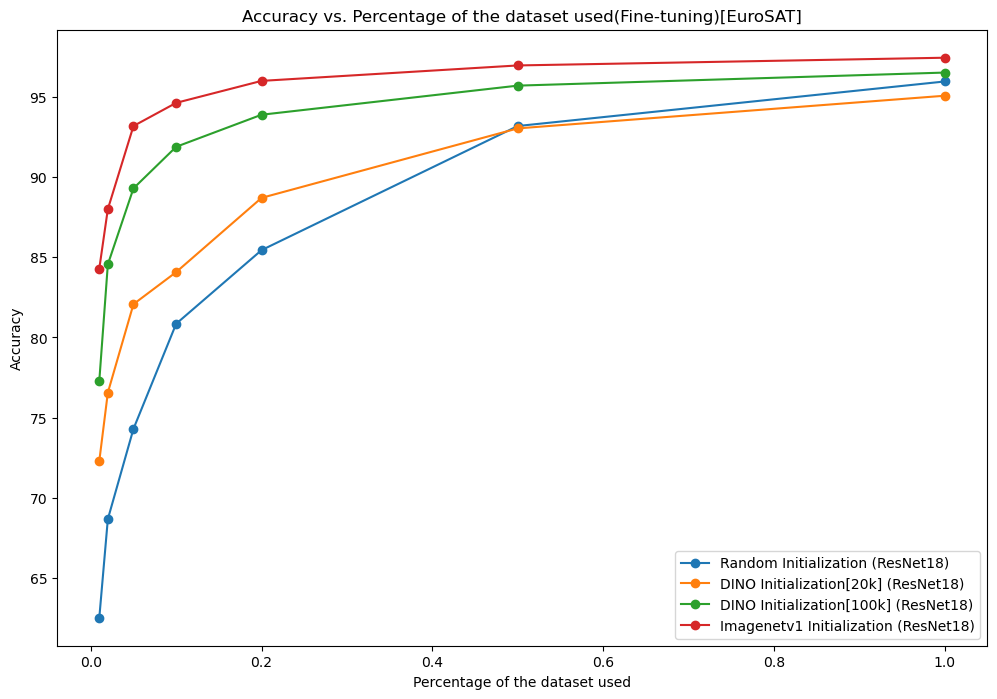

In [25]:
#plot all the list with legend
plt.figure(figsize=(12, 8))
plt.plot(percentage_list, None_fine_tuning, label='Random Initialization (ResNet18)', marker= 'o')
plt.plot(percentage_list, dino_30k_fine_tuning, label='DINO Initialization[20k] (ResNet18)', marker= 'o')
plt.plot(percentage_list, dino_100k_fine_tuning, label='DINO Initialization[100k] (ResNet18)', marker= 'o')
plt.plot(percentage_list, Imagenetv1_fine_tuning, label='Imagenetv1 Initialization (ResNet18)', marker= 'o')
plt.xlabel('Percentage of the dataset used')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Percentage of the dataset used(Fine-tuning)[EuroSAT]')
# plt.savefig('/home/akansh-i2sc/Desktop/Study/HLCV/Why-Self-Supervision-in-Time/figures/Accuracy vs. Percentage of the dataset used(Fine-tuning).png')


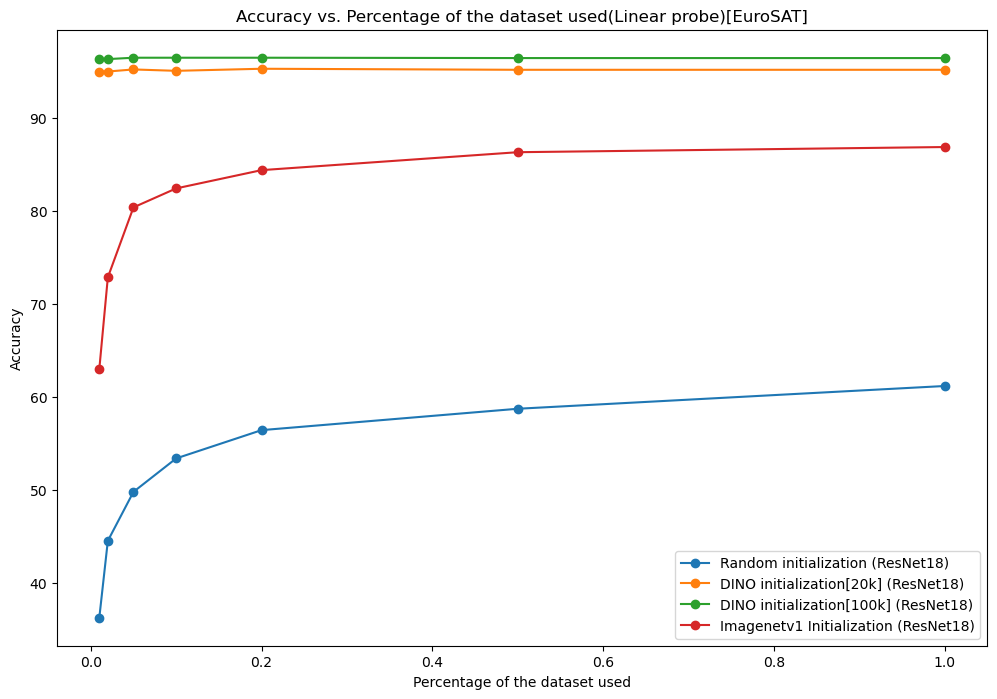

In [26]:
plt.figure(figsize=(12, 8))
plt.plot(percentage_list, None_linear_probe, label='Random initialization (ResNet18)', marker='o')
plt.plot(percentage_list, dino_30k_linear_probe, label='DINO initialization[20k] (ResNet18)', marker='o')
plt.plot(percentage_list, dino_100k_linear_probe, label='DINO initialization[100k] (ResNet18)', marker='o')
plt.plot(percentage_list, Imagenetv1_linear_probe, label='Imagenetv1 Initialization (ResNet18)', marker='o')
plt.xlabel('Percentage of the dataset used')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Percentage of the dataset used(Linear probe)[EuroSAT]')
plt.savefig('/home/akansh-i2sc/Desktop/Study/HLCV/Why-Self-Supervision-in-Time/figures/Accuracy vs. Percentage of the dataset used(Linear probe).png')

Loading Best Saved Model

In [10]:
model.load_state_dict(torch.load("/home/idisc02/Desktop/Hewan/hlcv/Why-Self-Supervision-in-Time/src/models/final_model.pth"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
def get_random_test_samples(test_dataset, num_samples=20):
    random.seed(42)
    test_samples = []
    test_labels = []
    for sample, label in random.sample(list(test_dataset), k=num_samples):
        test_samples.append(sample)
        test_labels.append(label)
    return test_samples, test_labels

def make_predictions(model, data):
    predictions = []
    for sample in data:
        sample = torch.unsqueeze(sample, dim=0)

        # Convert the sample to a different data type if it is a boolean tensor
        if sample.dtype == torch.bool:
            sample = sample.float()  # Convert to float32

        # Move the input data to the same device as the model
        sample = sample.to(device)

        pred_logit = model(sample)
        pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
        predictions.append(pred_prob.detach().cpu().numpy())
    return predictions

def get_predicted_classes(pred_probs):
    pred_probs_array = np.array(pred_probs)
    pred_probs_tensor = torch.tensor(pred_probs_array)
    pred_classes = pred_probs_tensor.argmax(dim=1)
    return pred_classes

def compare_predictions(test_labels, pred_classes, class_names):
    for true_label, pred_class in zip(test_labels, pred_classes):
        true_label_name = class_names[true_label]
        pred_label_name = class_names[pred_class]
        print(f"True Label: {true_label_name} | Predicted Label: {pred_label_name}")


# Get random test samples
test_samples, test_labels = get_random_test_samples(test_dataset, num_samples=20)

# Make predictions on test samples
pred_probs = make_predictions(model, test_samples)

# Get predicted classes
pred_classes = get_predicted_classes(pred_probs)

# Compare predictions with true labels
compare_predictions(test_labels, pred_classes, class_names)


True Label: SeaLake | Predicted Label: Forest
True Label: Forest | Predicted Label: Forest
True Label: AnnualCrop | Predicted Label: Highway
True Label: Highway | Predicted Label: Pasture
True Label: Highway | Predicted Label: Highway
True Label: Highway | Predicted Label: HerbaceousVegetation
True Label: Forest | Predicted Label: Forest
True Label: Forest | Predicted Label: Forest
True Label: River | Predicted Label: PermanentCrop
True Label: Forest | Predicted Label: Forest
True Label: SeaLake | Predicted Label: SeaLake
True Label: PermanentCrop | Predicted Label: Pasture
True Label: AnnualCrop | Predicted Label: AnnualCrop
True Label: AnnualCrop | Predicted Label: AnnualCrop
True Label: Forest | Predicted Label: Forest
True Label: HerbaceousVegetation | Predicted Label: HerbaceousVegetation
True Label: Highway | Predicted Label: River
True Label: Residential | Predicted Label: Residential
True Label: SeaLake | Predicted Label: SeaLake
True Label: AnnualCrop | Predicted Label: Pastur

Displaying Outputs

In [12]:
def display_output_images(test_samples, pred_classes, test_labels, class_names):
    # Set the figure size and number of rows and columns
    plt.figure(figsize=(15, 15))
    nrows = 5
    ncols = 4

    for i, sample in enumerate(test_samples):
        # Create a subplot
        plt.subplot(nrows, ncols, i+1)

        # Convert the sample to a numpy array and transpose it if necessary
        image_data = sample.squeeze().cpu().numpy()

        # Ensure the image data has the correct shape
        if len(image_data.shape) == 3:
            image_data = image_data.transpose(1, 2, 0)

        # Normalize the pixel values to the range [0, 1]
        image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

        # Plot the target image
        plt.imshow(image_data)

        # Find the prediction label (in text form, e.g. "Sandal")
        pred_label = class_names[pred_classes[i]]

        # Get the truth label (in text form, e.g. "T-shirt")
        truth_label = class_names[test_labels[i]] 

        # Create the title text of the plot
        title_text = f"Truth: {truth_label} | Pred: {pred_label}"

        # Check for equality and change title color accordingly
        if pred_label == truth_label:
            plt.title(title_text, fontsize=10, color="g")  # Green text if correct
        else:
            plt.title(title_text, fontsize=10, color="r")  # Red text if wrong

        plt.axis(False)

    plt.show()


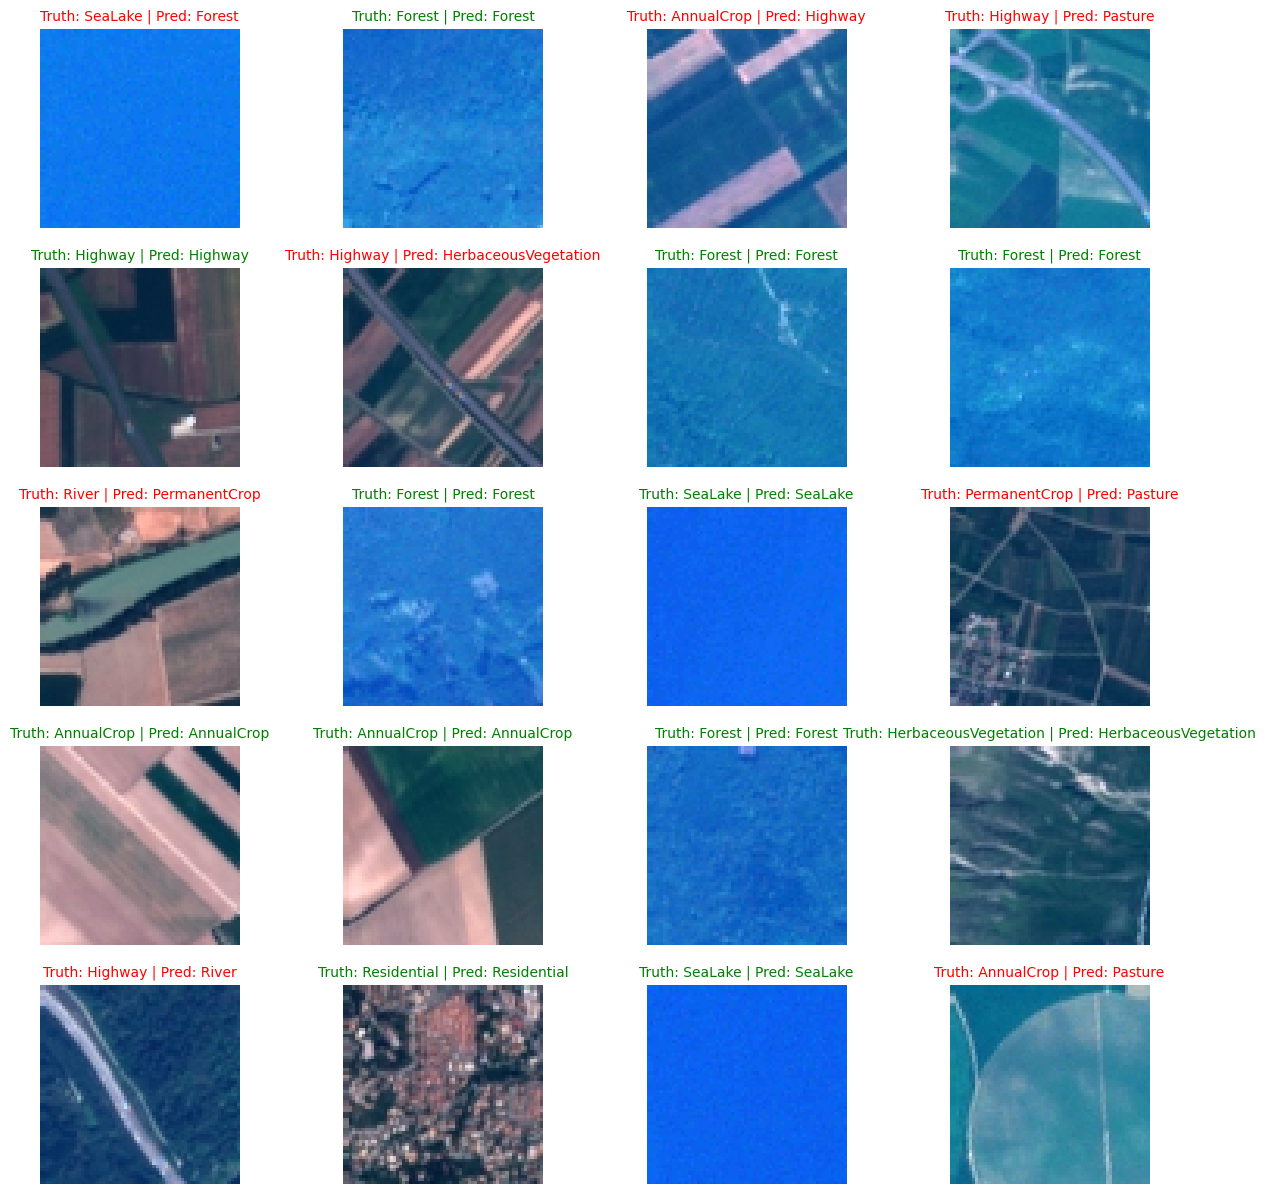

In [13]:
# Assuming you have the necessary variables defined
display_output_images(test_samples, pred_classes, test_labels, class_names)
